In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import random
import sys

sys.path.append('../')
from src.io_f import read_data_file
import src.compute_f as compute_f

In [4]:
floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2, "F4":3, "F5":4, "F6":5, "F7":6,"F8":7, "F9":8,
             "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5, "7F":6, "8F": 7, "9F":8}
            
base_path = '../input/indoor-location-navigation/'
sample_submission = pd.read_csv(base_path + 'sample_submission.csv')
used_buildings = sample_submission['site_path_timestamp'].str.split('_', expand=True)[0].unique()

In [5]:
used_buildings

array(['5a0546857ecc773753327266', '5c3c44b80379370013e0fd2b',
       '5d27075f03f801723c2e360f', '5d27096c03f801723c31e5e0',
       '5d27097f03f801723c320d97', '5d27099f03f801723c32511d',
       '5d2709a003f801723c3251bf', '5d2709b303f801723c327472',
       '5d2709bb03f801723c32852c', '5d2709c303f801723c3299ee',
       '5d2709d403f801723c32bd39', '5d2709e003f801723c32d896',
       '5da138274db8ce0c98bbd3d2', '5da1382d4db8ce0c98bbe92e',
       '5da138314db8ce0c98bbf3a0', '5da138364db8ce0c98bc00f1',
       '5da1383b4db8ce0c98bc11ab', '5da138754db8ce0c98bca82f',
       '5da138764db8ce0c98bcaa46', '5da1389e4db8ce0c98bd0547',
       '5da138b74db8ce0c98bd4774', '5da958dd46f8266d0737457b',
       '5dbc1d84c1eb61796cf7c010', '5dc8cea7659e181adb076a3f'],
      dtype=object)

In [11]:
# sample = {}
path_files = []
p = 0.01
for building in used_buildings:
    folders = sorted(glob.glob(os.path.join(base_path,'train/'+building+'/*')))
    wifi = list()
    for folder in folders:
        floor = floor_map[folder.split('/')[-1]]
        files = glob.glob(os.path.join(folder, "*.txt"))
        for file in files:
            path_files.append(file)
            # sample[building] = file
            break
        break 

In [12]:
path_files

['../input/indoor-location-navigation/train/5a0546857ecc773753327266/B1/5e1580d1f4c3420006d520e4.txt',
 '../input/indoor-location-navigation/train/5c3c44b80379370013e0fd2b/B1/5d0761dfb53a8d0008dd4c26.txt',
 '../input/indoor-location-navigation/train/5d27075f03f801723c2e360f/B1/5da9aac918410e00067e684d.txt',
 '../input/indoor-location-navigation/train/5d27096c03f801723c31e5e0/B1/5db805b65741f4000680a8f8.txt',
 '../input/indoor-location-navigation/train/5d27097f03f801723c320d97/B1/5dd0f21c94e4900006126045.txt',
 '../input/indoor-location-navigation/train/5d27099f03f801723c32511d/B1/5dce74c35516ad00065f034a.txt',
 '../input/indoor-location-navigation/train/5d2709a003f801723c3251bf/1F/5dbbd809dc27ae0006bbe60d.txt',
 '../input/indoor-location-navigation/train/5d2709b303f801723c327472/1F/5da83b7eae6cfc0006ca821b.txt',
 '../input/indoor-location-navigation/train/5d2709bb03f801723c32852c/B1/5dca36345e083300061bc838.txt',
 '../input/indoor-location-navigation/train/5d2709c303f801723c3299ee/1F/5

In [38]:
# 加速度と磁場？から相対位置を算出
# https://www.kaggle.com/saitodevel01/indoor-post-processing-by-cost-minimization
def compute_rel_positions(acce_datas, ahrs_datas):
    """
    input: (2316, 4) (timestamp, x, y, z)
    output: 
    """
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions


def correct_path(args):
    path, path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    
    example = read_data_file(f'{INPUT_PATH}/test/{path}.txt')
    rel_positions = compute_rel_positions(example.acce, example.ahrs)
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })


def complement_sensor_waypoint(trajectory_timestamp, trajectory_waypoint, sensor):
    sensor_timestamp = sensor[:, 0]
    sensor_rel_waypoint = sensor[:, 1:]
    sensor_waypoint = []
    for i in range(len(trajectory_timestamp)-1):
        # あるwaypointから次のwaypointの間にあるsensorデータを取り出したいのでtimestampで該当のidxを取得
        target_idx = (sensor_timestamp > trajectory_timestamp[i]) & (sensor_timestamp < trajectory_timestamp[i+1])
        # 対象区間の相対位置の累積和を取りスタート地点のwaypointを足すことでsensorによる位置が取得できる
        tmp_sensor_waypoint = trajectory_waypoint[i] + np.cumsum(sensor_rel_waypoint[target_idx], axis=0)
        sensor_waypoint.append(tmp_sensor_waypoint)
    sensor_waypoint = np.concatenate(sensor_waypoint)
    return sensor_timestamp, sensor_waypoint

In [27]:
example = read_data_file(path_files[0])
trajectory = example.waypoint
wifi = example.wifi
sensor = compute_rel_positions(example.acce, example.ahrs)

trajectory_timestamp = trajectory[:,0]
trajectory_waypoint = trajectory[:, 1:]
wifi_timestamp = np.unique(wifi[:, 0]).astype(int)

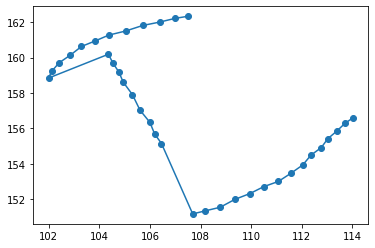

In [39]:
sensor_timestamp, sensor_waypoint = complement_sensor_waypoint(trajectory_timestamp, trajectory_waypoint, sensor)

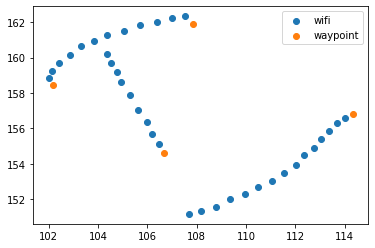

In [44]:
plt.scatter(sensor_waypoint[:,0], sensor_waypoint[:,1], label='wifi')
plt.scatter(trajectory_waypoint[:,0], trajectory_waypoint[:,1], label='waypoint')
plt.legend()

### センサを使った位置推定 part2

In [71]:
step_distance = 0.8
w_height = 1.7
m_trans = -5

In [85]:
mix_acce = np.sqrt(example.acce[:,1:2]**2 + example.acce[:,2:3]**2 + example.acce[:,3:4]**2)
mix_acce = np.concatenate([example.acce[:,0:1], mix_acce], 1)
mix_df = pd.DataFrame(mix_acce)
mix_df.columns = ["timestamp","acce"]
mix_df

,timestamp,acce
0,1.578466e+12,9.983129
1,1.578466e+12,10.118029
2,1.578466e+12,9.996192
3,1.578466e+12,9.958784
4,1.578466e+12,9.975923
...,...,...
1834,1.578466e+12,9.936211
1835,1.578466e+12,8.386364
1836,1.578466e+12,8.833745
1837,1.578466e+12,10.876840


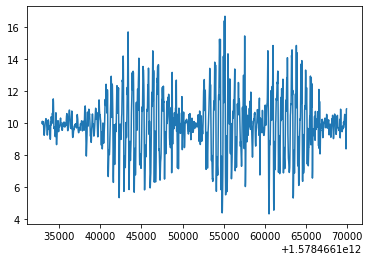

In [87]:
plt.plot(mix_df['timestamp'], mix_df['acce'])

In [88]:
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

order = 3
fs = 50.0  # sample rate, Hz
# fs = 100
# cutoff = 3.667  # desired cutoff frequency of the filter, Hz
cutoff = 3

filtered = butter_lowpass_filter(mix_df["acce"], cutoff, fs, order)
filtered

array([ 0.04742509,  0.29705171,  0.91905434, ..., 10.05752511,
        9.91506492,  9.77741099])